<center><h2>Setup - Environment & Dependencies</center></h2>

In [1]:
#Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import modf
from scipy import stats

%matplotlib inline

plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.axisbelow'] = True

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Import cleaned up CSV files
surface = pd.read_csv('./Resources/Cleaned/ttc_surface_route_delays.csv')
weather = pd.read_csv('./Resources/Cleaned/weather.csv')
holidays = pd.read_csv('./Resources/Cleaned/holidays.csv')

In [3]:
#Merging Surface data, weather and holidaya
surface['Report Date'] = pd.to_datetime(surface['Report Date'])
surface['Month'] = surface['Report Date'].dt.month
surface['nDay'] = surface['Report Date'].dt.day
surface = surface.rename(columns={'Report Date': 'Date'})
surface = surface.drop(columns=['Unnamed: 0'])

weather['Date/Time'] = pd.to_datetime(weather['Date/Time'])
weather = weather.rename(columns={
    'Date/Time': 'Date', 
    'Mean Temp (°C)': 'Mean Temp', 
    'Total Precip (mm)': 'Precipitation'
})
weather = weather.drop(columns={'Year', 'Month', 'Day'})

holidays = holidays.rename(columns={'date': 'Date', 'holiday': 'Holiday'})
holidays['Date'] = pd.to_datetime(holidays['Date'])

surface = pd.merge(surface, weather, on ='Date', how='left')
surface = pd.merge(surface, holidays, on ='Date', how='left')

surface['Holiday'] = surface['Holiday'].fillna('None')

surface = surface[surface['Min Delay'] < 7000]
surface['Route'] = surface['Route'].astype('category')
surface['Vehicle'] = surface['Vehicle'].astype('category')

surface['Incident'] = surface['Incident'].replace({
    'Late Leaving Garage - Mechanical': 'Late Leaving Garage',
    'Late Leaving Garage - Operator': 'Late Leaving Garage',
    'Late Leaving Garage - Management': 'Late Leaving Garage'
})

surface = surface[(surface['Min Delay'] >= 0) & (surface['Min Delay'] <= 30)]

In [4]:
#Export merged data
surface.to_csv('./Resources/Cleaned/surface_master.csv')

In [5]:
surface.sort_values('Min Delay').head(15)

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,...,nDay,Max Temp (°C),Min Temp (°C),Mean Temp,Total Rain (mm),Total Snow (cm),Precipitation,Snow on Grnd (cm),Spd of Max Gust (km/h),Holiday
169091,2017-12-13,113,17.22,Monday,maint stn,Investigation,0.0,28.0,B/W,7717.0,...,13,-7.1,-14.0,-10.5,0.0,0.4,0.3,7.0,28,None
480080,2015-09-16,501,19.50,Monday,NaN,Investigation,0.0,0.0,W/B,4053.0,...,16,27.9,15.2,21.6,0.0,0.0,0.0,0.0,31,None
145081,2017-08-20,36,23.50,Friday,Duncanwoods,Diversion,0.0,7.0,w,9112.0,...,20,27.6,15.0,21.3,0.0,0.0,0.0,0.0,36,None
117661,2017-03-26,134,7.05,Friday,Centennial College Loop,Late Leaving Garage,0.0,7.0,W,1251.0,...,26,6.5,0.6,3.6,1.7,0.0,2.7,0.0,53,None
58407,2018-05-22,320,7.83,Sunday,Montgomery Ave and Yonge,Mechanical,0.0,0.0,N/B,8322.0,...,22,17.2,10.2,13.8,1.9,0.0,4.5,0.0,33,None
145084,2017-08-21,7,0.00,Saturday,Bathurst Route,Diversion,0.0,0.0,b/w,NaN,...,21,28.9,17.3,23.1,0.2,0.0,0.2,0.0,31,None
5862,2019-02-01,73,6.73,Wednesday,Royal York and LaRose,Late Leaving Garage,0.0,27.0,N/B,8053.0,...,1,-9.2,-18.7,-14.0,0.0,0.0,0.0,16.0,24,None
13740,2019-03-03,138,6.37,Friday,Sweels and Brenroy,Late Leaving Garage,0.0,5.0,N/B,1567.0,...,3,-1.4,-8.2,-4.8,0.0,0.2,0.2,11.4,25,None
117639,2017-03-26,124,5.97,Friday,Lawrence Stn,Mechanical,0.0,12.0,e,1684.0,...,26,6.5,0.6,3.6,1.7,0.0,2.7,0.0,53,None
439243,2018-09-14,510,18.10,Wednesday,King Street,Mechanical,0.0,0.0,N/B,4435.0,...,14,27.7,19.0,23.4,0.0,0.0,0.0,0.0,31,None


In [6]:
holidays.head()

,Date,Holiday
0,2012-01-02,New Year's Day
1,2012-02-20,Family Day
2,2012-04-06,Good Friday
3,2012-05-21,Victoria Day
4,2012-07-02,Canada Day


In [7]:
weather.head()

,Date,Max Temp (°C),Min Temp (°C),Mean Temp,Total Rain (mm),Total Snow (cm),Precipitation,Snow on Grnd (cm),Spd of Max Gust (km/h)
0,2014-01-01,-9.4,-14.9,-12.2,0.0,0.0,0.0,7.4,32
1,2014-01-02,-15.3,-19.7,-17.5,0.0,0.4,0.8,7.2,38
2,2014-01-03,-7.6,-23.6,-15.6,0.0,0.0,0.0,7.6,34
3,2014-01-04,-0.1,-9.6,-4.9,0.0,0.9,1.0,7.6,43
4,2014-01-05,0.8,-2.6,-1.0,1.4,6.9,12.9,8.8,31


In [8]:
surface.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471257 entries, 0 to 494168
Data columns (total 23 columns):
Date                      471257 non-null datetime64[ns]
Route                     471257 non-null category
Time                      471257 non-null float64
Day                       471257 non-null object
Location                  470377 non-null object
Incident                  470328 non-null object
Min Delay                 471257 non-null float64
Min Gap                   470735 non-null float64
Direction                 462226 non-null object
Vehicle                   412332 non-null category
Year                      471257 non-null int64
Type                      471257 non-null object
Month                     471257 non-null int64
nDay                      471257 non-null int64
Max Temp (°C)             471257 non-null float64
Min Temp (°C)             471257 non-null float64
Mean Temp                 471257 non-null float64
Total Rain (mm)           471257 non-null

<center><h2>Impact of Precipitation on Minutes Delayed by Route</center></h2>

In [9]:
http://localhost:8889/notebooks/Documents/UofT%20SCS%20Data%20Analytics%20Bootcamp/Project1/ttc-delays/Surface%20Routes/surface_routes_eda.ipynb#Histogram-of-Surface-Routes---Minutes-Delayedroutes = surface.groupby(['Date', 'Route']).agg({'Min Delay': 'sum', 'Precipitation': 'sum'}).reset_index()

routes_precip = routes[routes['Precipitation'] > 10]

routes_precip = routes_precip.sample(100)

### Histogram of Surface Routes - Minutes Delayed

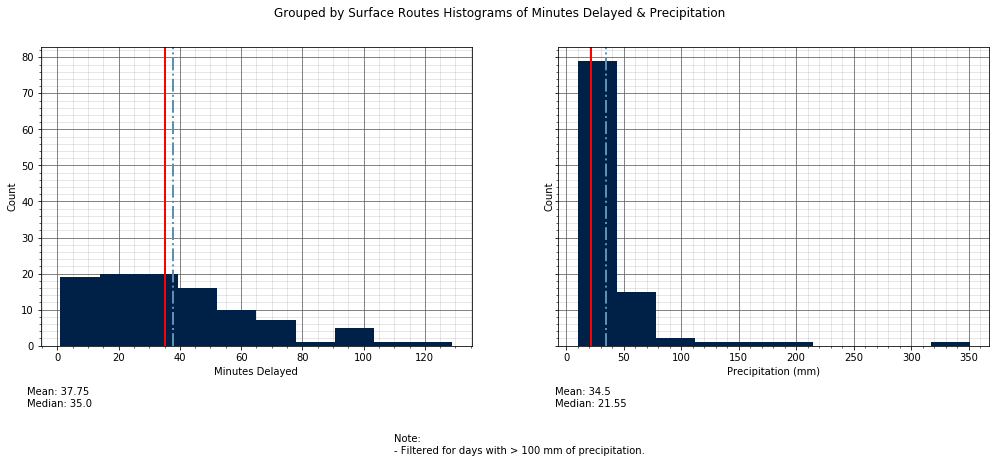

In [10]:
route_mean_min = routes_precip['Min Delay'].mean()
route_median_min = routes_precip['Min Delay'].median()
route_mean_precip = routes_precip['Precipitation'].mean()
route_median_precip = routes_precip['Precipitation'].median()

fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize = [17, 5.5])

# Plot 1
ax = axs[0]
ax.hist(
    routes_precip['Min Delay'], 
    bins = 10,
    color = '#002147'
)

ax.axvline(
    route_mean_min, 
    lw = 2, 
    color = '#5F90B2',
    ls = '-.'
)

ax.axvline(
    route_median_min, 
    lw = 2, 
    color = 'red'
)

ax.set_ylabel('Count')
ax.set_xlabel('Minutes Delayed')

ax.text(-10, -17, f'Mean: {round(route_mean_min, 2)} \
                    \nMedian: {round(route_median_min, 2)}')
ax.grid(
    b = True, 
    which = 'major', 
    color = '#666666', 
    linestyle = '-'
)

ax.minorticks_on()
ax.grid(
    b = True, 
    which = 'minor', 
    color = '#666666', 
    linestyle = '-', 
    alpha = 0.2
)

# Plot 2
ax = axs[1]

ax.hist(
    routes_precip['Precipitation'], 
    bins = 10, 
    color = '#002147'
)

ax.axvline(
    route_mean_precip, 
    lw = 2, 
    color = '#5F90B2',
    ls = '-.'
)

ax.axvline(
    route_median_precip, 
    lw = 2, 
    color = 'red'
)

ax.set_ylabel('Count')
ax.set_xlabel('Precipitation (mm)')

ax.text(-10, -17, f'Mean: {round(route_mean_precip, 2)} \
                    \nMedian: {round(route_median_precip, 2)}')

ax.grid(
    b = True, 
    which = 'major', 
    color = '#666666', 
    linestyle = '-'
)

ax.minorticks_on()
ax.grid(
    b = True, 
    which = 'minor', 
    color = '#666666', 
    linestyle = '-', 
    alpha = 0.2
)

fig.suptitle('Grouped by Surface Routes Histograms of Minutes Delayed & Precipitation')
plt.text(-150, -30, 'Note: \n- Filtered for days with > 100 mm of precipitation.')

plt.savefig('./Output/TTC Surface Route Histograms (Min Delay, Precipitation).png')
plt.show()

### Linear Regression - Surface Routes: Precipitation vs. Minutes Delayed

In [11]:
x = routes_precip['Precipitation']
y = routes_precip['Min Delay']

slope, intercept, rvalue, pvalue, std_err = stats.linregress(x, y)
fit = slope * x + intercept

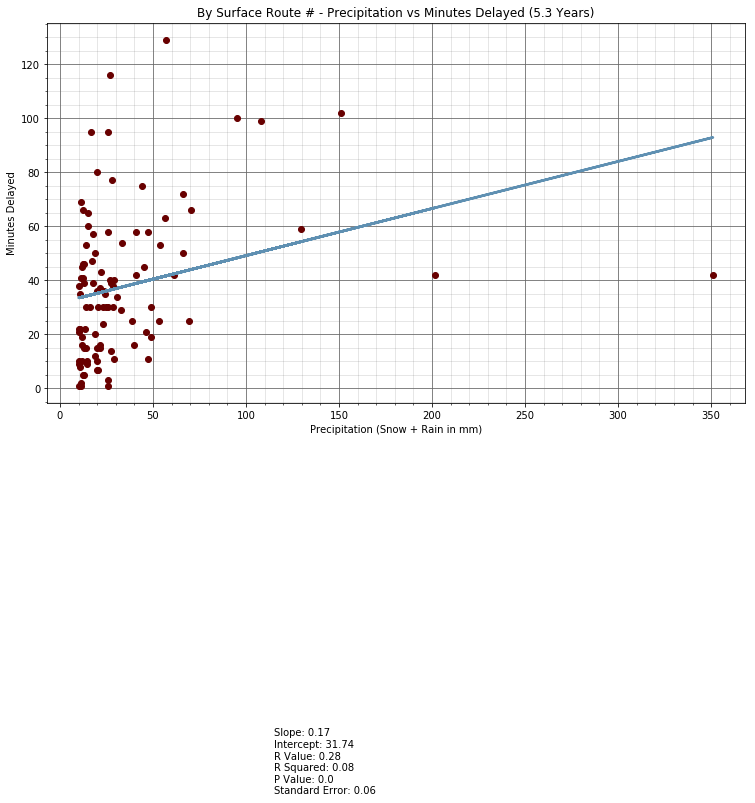

In [12]:
fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.scatter(
    routes_precip['Precipitation'], 
    routes_precip['Min Delay'],
    color = '#680000'
)

ax.plot(routes_precip['Precipitation'], fit, color = '#5F90B2', linewidth = 2.5)

ax.set_ylabel('Minutes Delayed')
ax.set_xlabel('Precipitation (Snow + Rain in mm)')
ax.set_title('By Surface Route # - Precipitation vs Minutes Delayed (5.3 Years)')

plt.grid(which = 'major', color = '#666666', linestyle = '-')
plt.minorticks_on()
plt.grid(which = 'minor', color = '#666666', linestyle = '-', alpha = 0.2)

plt.text(115, -150, f'Slope: {round(slope, 2)} \
                    \nIntercept: {round(intercept, 2)} \
                    \nR Value: {round(rvalue, 2)} \
                    \nR Squared: {round(rvalue**2, 2)} \
                    \nP Value: {round(pvalue, 2)} \
                    \nStandard Error: {round(std_err, 2)}')

plt.show()

<center><h2>Exploratory Scatterplot</center</h2>

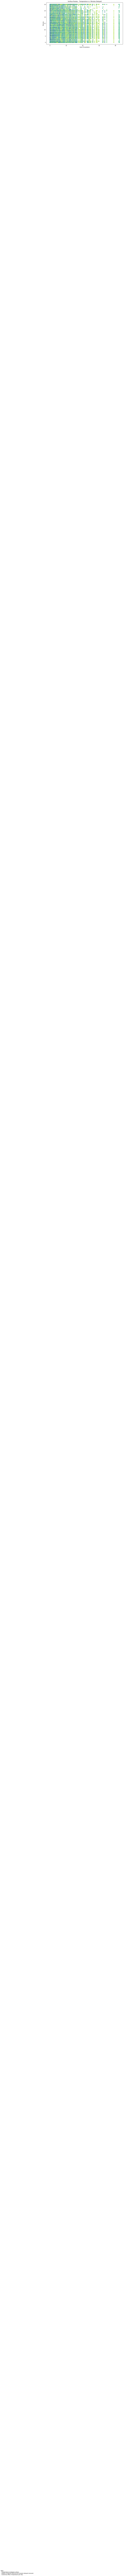

In [13]:
fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.scatter(
    surface['Precipitation'], 
    surface['Min Delay'], 
    c=surface['Mean Temp'], 
    alpha = 0.5
)

ax.set_ylabel('Minutes')
ax.set_xlabel('Daily Precipitation')
ax.set_title('Surface Routes - Temperature vs. Minutes Delayed')

plt.text(-30, -2000, 'Note: \
                    \n- Temperature in degrees celsius. \
                    \n- Outlier of 246245 (2014-03-03) minutes delayed removed. \
                    \n- Colored by Mean Temperature per Day')

plt.tight_layout()
plt.savefig('./Output/Surface Routes - Temperature vs. Minutes Delayed.png')
plt.show()

In [14]:
vehicles = surface.groupby(['Date', 'Route', 'Vehicle']).agg({'Min Delay': 'sum', 'Min Gap': 'sum', 'Precipitation': 'sum'})
vehicles = vehicles.rename(columns={'Min Delay': 'Total Minutes', 'Min Gap': 'Total Gap'}).reset_index()
vehicles.head(10)

,Date,Route,Vehicle,Total Minutes,Total Gap,Precipitation
0,2014-01-03,5,8337.0,15.0,30.0,0.0
1,2014-01-03,6,1534.0,26.0,52.0,0.0
2,2014-01-03,7,8169.0,9.0,18.0,0.0
3,2014-01-03,7,8194.0,9.0,18.0,0.0
4,2014-01-03,9,7882.0,20.0,40.0,0.0
5,2014-01-03,10,8331.0,1.0,1.0,0.0
6,2014-01-03,12,7886.0,50.0,100.0,0.0
7,2014-01-03,21,7740.0,16.0,32.0,0.0
8,2014-01-03,24,7843.0,10.0,20.0,0.0
9,2014-01-03,25,7612.0,6.0,12.0,0.0


In [15]:
vehicles['Total Minutes'].mean(), vehicles['Total Gap'].mean()

(10.680716098469903, 20.818432433670782)

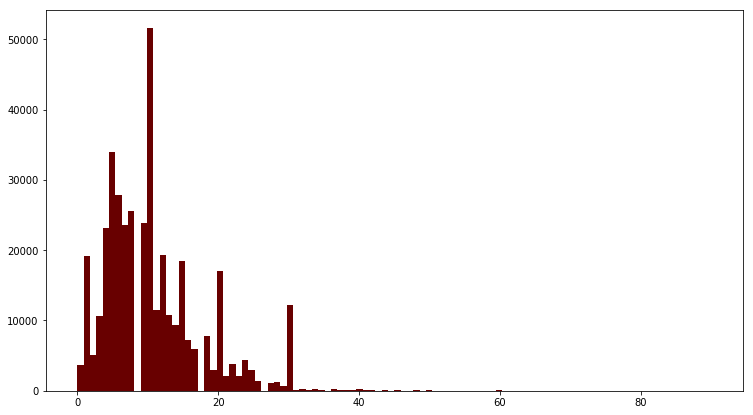

In [16]:
vehicles = vehicles[vehicles['Total Minutes'] < 200]

fig, ax = plt.subplots(1, figsize=[12.5, 7])

ax.hist(vehicles['Total Minutes'], bins = 100, color = '#680000')

plt.show()

<center><h2>Delay Time</h2></center>

In [17]:
groupedbyday = surface.groupby(['Date', 'Day']).agg({'Min Delay': 'sum'})
groupedbyday = groupedbyday.reset_index()
groupedbyday

,Date,Day,Min Delay
0,2014-01-03,Wednesday,1639.0
1,2014-01-04,Thursday,4520.0
2,2014-01-05,Friday,5981.0
3,2014-01-06,Saturday,2755.0
4,2014-01-07,Sunday,1380.0
5,2014-01-08,Monday,4456.0
6,2014-01-09,Tuesday,6479.0
7,2014-01-10,Wednesday,4772.0
8,2014-01-11,Thursday,3716.0
9,2014-01-12,Friday,3931.0


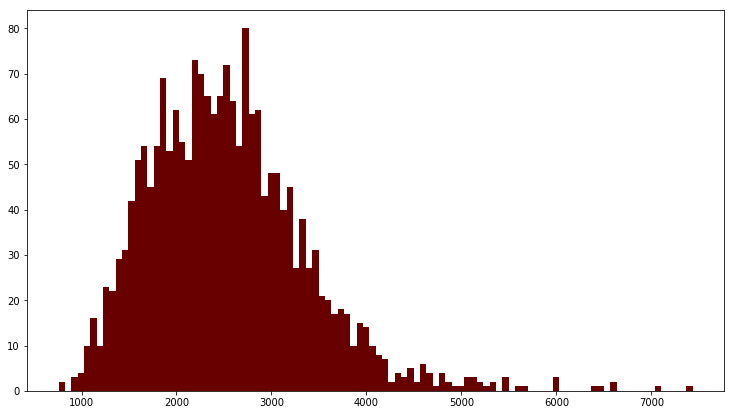

In [18]:


fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.hist(groupedbyday['Min Delay'], bins = 100, color = '#680000')

plt.show()

In [19]:
groupedbyday.mean(), groupedbyday.median()

(Min Delay    2534.029337
 dtype: float64, Min Delay    2459.0
 dtype: float64)

In [20]:
totaldays = len(groupedbyday)
totalmin = groupedbyday['Min Delay'].sum()
meanminperday = round(groupedbyday['Min Delay'].mean(), 2)
medianminperday = round(groupedbyday['Min Delay'].median(), 2)
daysdelay = round((groupedbyday['Min Delay'].sum()/60)/24, 2)
percdelay = round((daysdelay / totaldays)/100, 2)
sigmaday = round(groupedbyday['Min Delay'].std(), 2)
delayvariance = round(sigmaday ** 2, 2)

delaystats_dict = {
    'Total Days': totaldays,
    'Total Minutes': daysdelay,
    'Mean Min. per Day': meanminperday,
    'Median Min. per Day': medianminperday,
    '% of Days Delayed': percdelay,
    'Daily Sigma': sigmaday,
    'Delay Variance': delayvariance
}

delaystats = pd.DataFrame(delaystats_dict, index=['Stats'])

delaystats = delaystats.style.format({
    '% of Days Delayed': '{:.2%}'.format
})

In [21]:
totaldays, totalmin, meanminperday, medianminperday, daysdelay, percdelay, sigmaday, delayvariance

(1977, 5009776.0, 2534.03, 2459.0, 3479.01, 0.02, 832.38, 692856.46)

In [22]:
delaystats

,Total Days,Total Minutes,Mean Min. per Day,Median Min. per Day,% of Days Delayed,Daily Sigma,Delay Variance
Stats,1977,3479.01,2534.03,2459,2.00%,832.38,692856


In [23]:
surface.head()

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,...,nDay,Max Temp (°C),Min Temp (°C),Mean Temp,Total Rain (mm),Total Snow (cm),Precipitation,Snow on Grnd (cm),Spd of Max Gust (km/h),Holiday
0,2019-01-03,39,0.22,Tuesday,NECR,Mechanical,9.0,18.0,W/B,1794.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None
1,2019-01-03,111,0.25,Tuesday,Eglington,Mechanical,15.0,30.0,S/B,8065.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None
2,2019-01-03,35,0.30,Tuesday,Finch,Mechanical,9.0,18.0,S/B,3275.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None
3,2019-01-03,25,0.50,Tuesday,Don Mills Rd/Eglinton Ave E,Mechanical,9.0,18.0,N/B,8840.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None
4,2019-01-03,36,0.67,Tuesday,Humberwood,Investigation,9.0,18.0,E/B,9119.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None


In [24]:
incidents = surface.groupby('Incident').agg({'Min Delay': 'sum', 'Min Gap': 'sum'}).sort_values('Min Delay')
incidents = incidents.reset_index()
incidents

,Incident,Min Delay,Min Gap
0,Vision,708.0,1657.0
1,Overhead - Pantograph,788.0,1613.0
2,Held By,79154.0,128699.0
3,Emergency Services,118847.0,230846.0
4,Diversion,142588.0,420346.0
5,Investigation,522107.0,1008794.0
6,Utilized Off Route,573237.0,1132237.0
7,Late Leaving Garage,700837.0,1331797.0
8,General Delay,881223.0,1294580.0
9,Mechanical,1980221.0,3879876.0


In [25]:
names = incidents['Incident'].unique().tolist()
names

['Vision',
 'Overhead - Pantograph',
 'Held By',
 'Emergency Services',
 'Diversion',
 'Investigation',
 'Utilized Off Route',
 'Late Leaving Garage',
 'General Delay',
 'Mechanical']

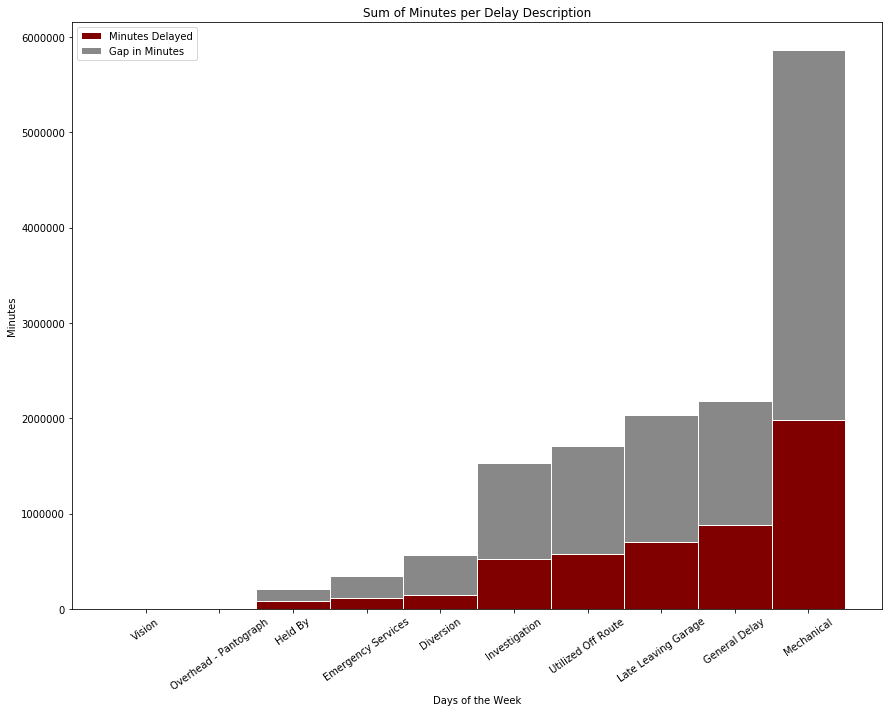

In [26]:
bar1 = incidents['Min Delay']
bar2 = incidents['Min Gap']

label = incidents['Incident']
barwidth = 1

description = incidents['Incident'].unique().tolist()
description_order = [0,1, 2, 3, 4, 5, 6, 7, 8, 9]
descriptions = [description[i] for i in description_order]

bars = np.add(bar1, bar2).tolist()

fig, ax = plt.subplots(1, figsize = [12.5, 10])

p1 = ax.bar(label, bar1, color='#800000', edgecolor='white', width=barwidth)
p2 = ax.bar(label, bar2, bottom=bar1, color='#888888', edgecolor='white', width=barwidth)

ax.set_ylabel('Minutes')
ax.set_xlabel('Days of the Week')
ax.set_title('Sum of Minutes per Delay Description')

plt.legend((p1[0], p2[0]), ('Minutes Delayed', 'Gap in Minutes'))

plt.xticks(label, descriptions, rotation = 35)

plt.tight_layout()

plt.savefig('./Output/Sum of Minutes per Delay Description.png')
plt.show()

<center><h2>Time of Day</center></h2>

In [27]:
surface.head()

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,...,nDay,Max Temp (°C),Min Temp (°C),Mean Temp,Total Rain (mm),Total Snow (cm),Precipitation,Snow on Grnd (cm),Spd of Max Gust (km/h),Holiday
0,2019-01-03,39,0.22,Tuesday,NECR,Mechanical,9.0,18.0,W/B,1794.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None
1,2019-01-03,111,0.25,Tuesday,Eglington,Mechanical,15.0,30.0,S/B,8065.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None
2,2019-01-03,35,0.30,Tuesday,Finch,Mechanical,9.0,18.0,S/B,3275.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None
3,2019-01-03,25,0.50,Tuesday,Don Mills Rd/Eglinton Ave E,Mechanical,9.0,18.0,N/B,8840.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None
4,2019-01-03,36,0.67,Tuesday,Humberwood,Investigation,9.0,18.0,E/B,9119.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None


In [28]:
surface.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471257 entries, 0 to 494168
Data columns (total 23 columns):
Date                      471257 non-null datetime64[ns]
Route                     471257 non-null category
Time                      471257 non-null float64
Day                       471257 non-null object
Location                  470377 non-null object
Incident                  470328 non-null object
Min Delay                 471257 non-null float64
Min Gap                   470735 non-null float64
Direction                 462226 non-null object
Vehicle                   412332 non-null category
Year                      471257 non-null int64
Type                      471257 non-null object
Month                     471257 non-null int64
nDay                      471257 non-null int64
Max Temp (°C)             471257 non-null float64
Min Temp (°C)             471257 non-null float64
Mean Temp                 471257 non-null float64
Total Rain (mm)           471257 non-null

In [29]:
surface.head()

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,...,nDay,Max Temp (°C),Min Temp (°C),Mean Temp,Total Rain (mm),Total Snow (cm),Precipitation,Snow on Grnd (cm),Spd of Max Gust (km/h),Holiday
0,2019-01-03,39,0.22,Tuesday,NECR,Mechanical,9.0,18.0,W/B,1794.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None
1,2019-01-03,111,0.25,Tuesday,Eglington,Mechanical,15.0,30.0,S/B,8065.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None
2,2019-01-03,35,0.30,Tuesday,Finch,Mechanical,9.0,18.0,S/B,3275.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None
3,2019-01-03,25,0.50,Tuesday,Don Mills Rd/Eglinton Ave E,Mechanical,9.0,18.0,N/B,8840.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None
4,2019-01-03,36,0.67,Tuesday,Humberwood,Investigation,9.0,18.0,E/B,9119.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None


In [30]:
timeofday = surface.groupby(['Day', 'Time']).agg({'Min Delay': 'sum'}).reset_index()
timeofday = timeofday[timeofday['Time'] < 24]
timeofday['Hour'] = round(((timeofday['Time'] / 1) * 60) / 60, 0)
dailyincidents = surface.groupby(['Day', 'Time']).agg({'Min Delay': 'count'}).reset_index()
dailyincidents = dailyincidents.rename(columns={'Min Delay': 'Counts'})
timeofday['Counts'] = dailyincidents['Counts']

timeofday.head()

,Day,Time,Min Delay,Hour,Counts
0,Friday,0.00,628.0,0.0,47
1,Friday,0.02,286.0,0.0,20
2,Friday,0.03,128.0,0.0,9
3,Friday,0.05,128.0,0.0,11
4,Friday,0.07,109.0,0.0,8


In [31]:

dailyincidents.head()

,Day,Time,Counts
0,Friday,0.00,47
1,Friday,0.02,20
2,Friday,0.03,9
3,Friday,0.05,11
4,Friday,0.07,8


In [32]:
weeklysum = timeofday.groupby(['Day', 'Hour']).agg({'Min Delay': 'sum', 'Counts': 'sum'}).reset_index().reset_index()
weeklysum = weeklysum.rename(columns={'index': 'Chronological', 'Min Delay': 'Min Sum'})
minmean = timeofday.groupby(['Day', 'Hour']).agg({'Min Delay': 'mean'}).rename(columns={'Min Delay': 'Min Mean'}).reset_index()
weeklysum['Min Mean'] = round(minmean['Min Mean'], 2)


weeklysum.tail()

,Chronological,Day,Hour,Min Sum,Counts,Min Mean
170,170,Wednesday,20.0,20283.0,1888,332.51
171,171,Wednesday,21.0,17462.0,1580,295.97
172,172,Wednesday,22.0,17359.0,1463,284.57
173,173,Wednesday,23.0,11178.0,861,189.46
174,174,Wednesday,24.0,5902.0,453,196.73


In [33]:
weeklysum.head()

,Chronological,Day,Hour,Min Sum,Counts,Min Mean
0,0,Friday,0.0,6807.0,515,219.58
1,1,Friday,1.0,9506.0,744,161.12
2,2,Friday,2.0,7220.0,586,118.36
3,3,Friday,3.0,5355.0,353,92.33
4,4,Friday,4.0,5717.0,362,93.72


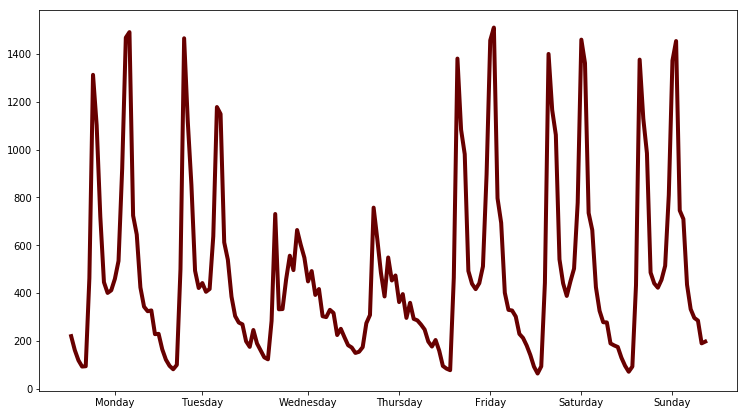

In [34]:
ticks = [12, 36, 65, 90, 115, 140, 165]
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.plot(
    weeklysum['Chronological'], 
    weeklysum['Min Mean'],
    c = '#680000',
    linewidth = 4
)

plt.xticks(ticks = ticks, labels = labels)


plt.show()

### Incidents

In [35]:
surface.head()

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,...,nDay,Max Temp (°C),Min Temp (°C),Mean Temp,Total Rain (mm),Total Snow (cm),Precipitation,Snow on Grnd (cm),Spd of Max Gust (km/h),Holiday
0,2019-01-03,39,0.22,Tuesday,NECR,Mechanical,9.0,18.0,W/B,1794.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None
1,2019-01-03,111,0.25,Tuesday,Eglington,Mechanical,15.0,30.0,S/B,8065.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None
2,2019-01-03,35,0.30,Tuesday,Finch,Mechanical,9.0,18.0,S/B,3275.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None
3,2019-01-03,25,0.50,Tuesday,Don Mills Rd/Eglinton Ave E,Mechanical,9.0,18.0,N/B,8840.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None
4,2019-01-03,36,0.67,Tuesday,Humberwood,Investigation,9.0,18.0,E/B,9119.0,...,3,1.3,-2.5,-0.6,0.0,0.0,0.0,2.8,44,None


In [36]:
incidents = surface.groupby(['Incident']).agg({'Min Delay': 'sum', 'Precipitation': 'sum'}).reset_index()
incidents

,Incident,Min Delay,Precipitation
0,Diversion,142588.0,23014.2
1,Emergency Services,118847.0,20888.5
2,General Delay,881223.0,131205.2
3,Held By,79154.0,12974.4
4,Investigation,522107.0,99442.1
5,Late Leaving Garage,700837.0,145456.6
6,Mechanical,1980221.0,381484.8
7,Overhead - Pantograph,788.0,244.1
8,Utilized Off Route,573237.0,137607.7
9,Vision,708.0,264.5


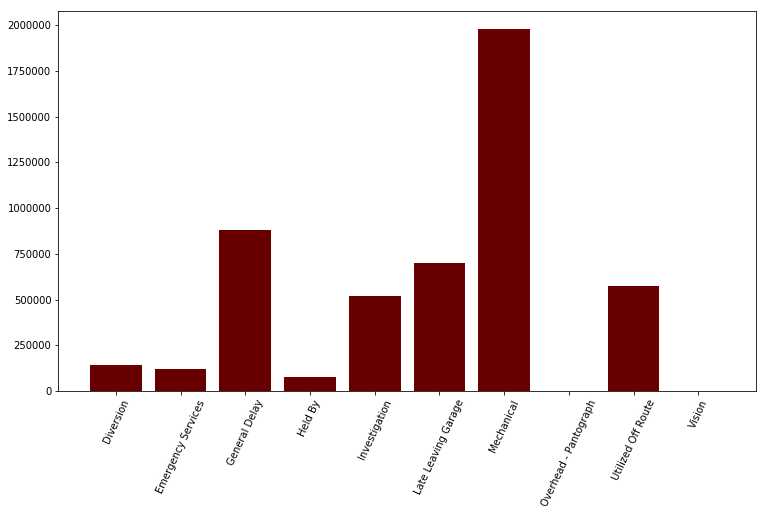

In [37]:
fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.bar(incidents['Incident'], incidents['Min Delay'], color='#680000')

plt.xticks(rotation=65)

plt.show()

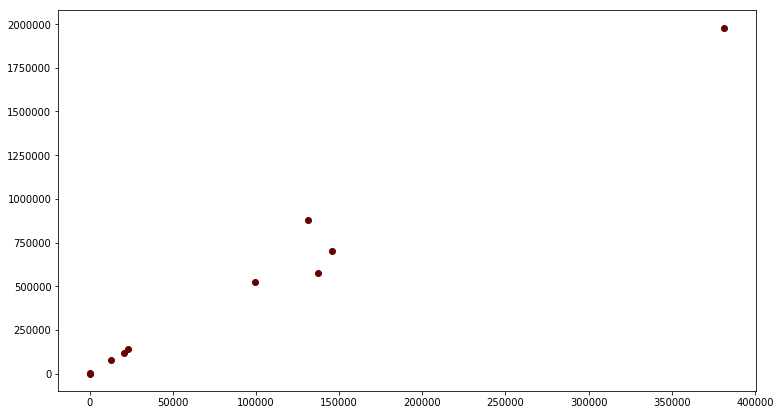

In [38]:
fig, ax = plt.subplots(1, figsize = [12.5, 7])

ax.scatter(incidents['Precipitation'], incidents['Min Delay'], color='#680000')

plt.show()